# MovieLens Exploratory Data Analysis and Modeling

This notebook performs **exploratory analysis** and **movie profiling** on the MovieLens 32M dataset to understand patterns, trends, and characteristics in user ratings and movie metadata.

## What This Notebook Does

- Load and clean MovieLens data (ratings, movies, tags, links)
- Explore distributions: ratings, genres, release years, user tags
- Analyze trends: genre popularity over time, rating evolution by decade
- Build ML models for **movie-level insights** (NOT user recommendations):
  - **Clustering (K-Means)**: Group movies by year and rating characteristics
  - **Classification (Random Forest)**: Predict movie quality tier (Low/Medium/High)
  - **Regression (Random Forest)**: Estimate average movie ratings
  - **Association Rules (FP-Growth)**: Discover frequent genre combinations
- Generate interactive visualizations with Plotly

## For User Recommendations

See: **Recommender.ipynb** (ALS collaborative filtering for personalized top-N recommendations)

## Expected Runtime

15-30 minutes (depending on dataset size and hardware)

## Dataset

- MovieLens 32M (or latest-small for testing)
- Auto-downloads via scripts/download_movielens.py if missing
- Stored in data/movielens/32m/

# Load and check datasets

Run cells top-to-bottom to: (1) verify packages, (2) download/read MovieLens 32M locally, (3) ready for cleaning and analysis steps.


In [1]:
import pyspark
print(pyspark.__version__)

3.5.6


## Dataset source (local)

The setup cell downloads the MovieLens 32M CSVs into `data/movielens/32m` if they are missing and exposes `data_paths` for later steps.


In [2]:
from pathlib import Path
import subprocess
import sys

DATA_VARIANT = "32m"  # matches README
DATA_FILES = {
    "movies": "movies.csv",
    "ratings": "ratings.csv",
    "tags": "tags.csv",
    "links": "links.csv",
}


def find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "scripts" / "download_movielens.py").exists():
            return candidate
    raise FileNotFoundError("Could not locate repository root from the current working directory.")


def ensure_local_dataset(variant: str) -> Path:
    repo_root = find_repo_root(Path.cwd())
    variant_dir = repo_root / "data" / "movielens" / variant
    missing = [name for name in DATA_FILES.values() if not (variant_dir / name).exists()]
    if not missing:
        print(f"Using local files at {variant_dir}")
        return variant_dir

    script_path = repo_root / "scripts" / "download_movielens.py"
    if not script_path.exists():
        raise FileNotFoundError(f"Cannot find {script_path} to download MovieLens {variant}")

    print(f"Local files missing; downloading MovieLens {variant} via {script_path}")
    subprocess.run([sys.executable, str(script_path), "--variant", variant], check=True, cwd=repo_root)

    missing = [name for name in DATA_FILES.values() if not (variant_dir / name).exists()]
    if missing:
        raise FileNotFoundError(f"Download completed but missing files: {', '.join(missing)}")
    return variant_dir


local_data_dir = ensure_local_dataset(DATA_VARIANT)
data_paths = {
    name: str(local_data_dir / filename)
    for name, filename in DATA_FILES.items()
}

print("Reading from:", data_paths)


Using local files at c:\Users\User\github\TsungTseTu122\CloudComputing--MovieLens-Big-Data-Analytics-on-the-Cloud\data\movielens\32m
Reading from: {'movies': 'c:\\Users\\User\\github\\TsungTseTu122\\CloudComputing--MovieLens-Big-Data-Analytics-on-the-Cloud\\data\\movielens\\32m\\movies.csv', 'ratings': 'c:\\Users\\User\\github\\TsungTseTu122\\CloudComputing--MovieLens-Big-Data-Analytics-on-the-Cloud\\data\\movielens\\32m\\ratings.csv', 'tags': 'c:\\Users\\User\\github\\TsungTseTu122\\CloudComputing--MovieLens-Big-Data-Analytics-on-the-Cloud\\data\\movielens\\32m\\tags.csv', 'links': 'c:\\Users\\User\\github\\TsungTseTu122\\CloudComputing--MovieLens-Big-Data-Analytics-on-the-Cloud\\data\\movielens\\32m\\links.csv'}


### Pandas preview (quick peek)

Use this to inspect the data with pandas; it loads a capped sample to stay lightweight.


In [3]:
import pandas as pd

movies_pd = pd.read_csv(data_paths["movies"])
ratings_pd = pd.read_csv(data_paths["ratings"], nrows=200000)  # adjust nrows as needed

print(movies_pd.head())
print(ratings_pd.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858


## Spark session
unified entry point for programming Spark with the Dataset and DataFrame API

In [4]:
from pyspark.sql import SparkSession

# Create Spark session (local)
spark = (
    SparkSession.builder
    .master("local[*]")  # type: ignore[attr-defined]
    .appName('MovieLensAnalysis')
    .config('spark.driver.memory', '2g')
    .config('spark.sql.shuffle.partitions', '8')
    .getOrCreate()
)

spark


## Configuration

Set filtering thresholds to improve data quality by removing sparse users and movies.

In [ ]:
# Configuration: minimum interactions to filter out sparse users/movies
MIN_USER_INTERACTIONS = 20  # Users must have rated at least this many movies
MIN_MOVIE_INTERACTIONS = 20  # Movies must have at least this many ratings

print(f"Filter thresholds:")
print(f"  - Min ratings per user: {MIN_USER_INTERACTIONS}")
print(f"  - Min ratings per movie: {MIN_MOVIE_INTERACTIONS}")

In [5]:
# Load movies.csv (local)
movies_df = spark.read.csv(data_paths['movies'], header=True, inferSchema=True)

movies_df.show()


+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [6]:
# Load tags.csv (local)
tags_df = spark.read.csv(data_paths['tags'], header=True, inferSchema=True)

tags_df.show()


+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|    22|  26479|         Kevin Kline|1583038886|
|    22|  79592|            misogyny|1581476297|
|    22| 247150|          acrophobia|1622483469|
|    34|   2174|               music|1249808064|
|    34|   2174|               weird|1249808102|
|    34|   8623|        Steve Martin|1249808497|
|    55|   5766|the killls and th...|1319322078|
|    58|   7451|            bullying|1672551536|
|    58|   7451|              clique|1672551510|
|    58|   7451|       coming of age|1672551502|
|    58|   7451|              gossip|1672551527|
|    58|   7451|         high school|1672551496|
|    58|   7451|          teen movie|1672551500|
|    58|  49272|           '60s feel|1672551430|
|    58|  49272|                 007|1672551409|
|    58|  49272|              action|1672551403|
|    58|  49272|            assassin|1672551425|
|    58|  49272|    

In [7]:
# Load links.csv (local)
links_df = spark.read.csv(data_paths['links'], header=True, inferSchema=True)

links_df.show()



+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
|      6|113277|   949|
|      7|114319| 11860|
|      8|112302| 45325|
|      9|114576|  9091|
|     10|113189|   710|
|     11|112346|  9087|
|     12|112896| 12110|
|     13|112453| 21032|
|     14|113987| 10858|
|     15|112760|  1408|
|     16|112641|   524|
|     17|114388|  4584|
|     18|113101|     5|
|     19|112281|  9273|
|     20|113845| 11517|
+-------+------+------+
only showing top 20 rows



After accessing this dataset, which is simply links to IMDB and TMDB, it simply isn't worth analyzing, so we won't be using it but for display

In [8]:
# Load ratings.csv (local)
ratings_df = spark.read.csv(data_paths['ratings'], header=True, inferSchema=True)

ratings_df.show()


+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|944249077|
|     1|     25|   1.0|944250228|
|     1|     29|   2.0|943230976|
|     1|     30|   5.0|944249077|
|     1|     32|   5.0|943228858|
|     1|     34|   2.0|943228491|
|     1|     36|   1.0|944249008|
|     1|     80|   5.0|944248943|
|     1|    110|   3.0|943231119|
|     1|    111|   5.0|944249008|
|     1|    161|   1.0|943231162|
|     1|    166|   5.0|943228442|
|     1|    176|   4.0|944079496|
|     1|    223|   3.0|944082810|
|     1|    232|   5.0|943228442|
|     1|    260|   5.0|943228696|
|     1|    302|   4.0|944253272|
|     1|    306|   5.0|944248888|
|     1|    307|   5.0|944253207|
|     1|    322|   4.0|944053801|
+------+-------+------+---------+
only showing top 20 rows



## Filter Sparse Users and Movies

Remove users with few ratings and movies with few ratings to improve data quality and analysis accuracy.

In [ ]:
from pyspark.sql import functions as F

# Check initial counts
print(f"Before filtering:")
print(f"  Total ratings: {ratings_df.count():,}")
print(f"  Unique users: {ratings_df.select('userId').distinct().count():,}")
print(f"  Unique movies: {ratings_df.select('movieId').distinct().count():,}")

In [ ]:
# Count interactions per user
user_counts = ratings_df.groupBy("userId").count()
active_users = user_counts.filter(F.col("count") >= MIN_USER_INTERACTIONS).select("userId")

print(f"Active users (>= {MIN_USER_INTERACTIONS} ratings): {active_users.count():,}")

In [ ]:
# Count interactions per movie
movie_counts = ratings_df.groupBy("movieId").count()
popular_movies = movie_counts.filter(F.col("count") >= MIN_MOVIE_INTERACTIONS).select("movieId")

print(f"Popular movies (>= {MIN_MOVIE_INTERACTIONS} ratings): {popular_movies.count():,}")

In [ ]:
# Filter ratings to keep only active users and popular movies
ratings_df_filtered = ratings_df \
    .join(active_users, "userId", "inner") \
    .join(popular_movies, "movieId", "inner")

print(f"\nAfter filtering:")
print(f"  Total ratings: {ratings_df_filtered.count():,}")
print(f"  Unique users: {ratings_df_filtered.select('userId').distinct().count():,}")
print(f"  Unique movies: {ratings_df_filtered.select('movieId').distinct().count():,}")

# Use filtered ratings for all subsequent analysis
ratings_df = ratings_df_filtered

### Filter tags and movies to match filtered ratings

Keep only tags and movies that are present in the filtered ratings dataset.

In [ ]:
# Filter tags to only include active users and popular movies
if tags_df.count() > 0:
    print(f"Tags before filtering: {tags_df.count():,}")
    tags_df = tags_df \
        .join(active_users, "userId", "inner") \
        .join(popular_movies, "movieId", "inner")
    print(f"Tags after filtering: {tags_df.count():,}")
else:
    print("No tags to filter")

In [ ]:
# Filter movies to only include popular movies
print(f"Movies before filtering: {movies_df.count():,}")
movies_df = movies_df.join(popular_movies, "movieId", "inner")
print(f"Movies after filtering: {movies_df.count():,}")

# Preprocessing

## Preprocessing Movies Data

In [9]:
from pyspark.sql.functions import regexp_extract

# Extract the year from the title using regex
movies_df = movies_df.withColumn("year", regexp_extract(movies_df["title"], r'\((\d{4})\)', 1))

# Clean title by removing the year
movies_df = movies_df.withColumn("clean_title", regexp_extract(movies_df["title"], r'^(.*)\s\(\d{4}\)$', 1))

# Create new DataFrame and drop the original 'title' column
split_movies_df = movies_df.drop("title")

# Show the resulting DataFrame
split_movies_df.show()



+-------+--------------------+----+--------------------+
|movieId|              genres|year|         clean_title|
+-------+--------------------+----+--------------------+
|      1|Adventure|Animati...|1995|           Toy Story|
|      2|Adventure|Childre...|1995|             Jumanji|
|      3|      Comedy|Romance|1995|    Grumpier Old Men|
|      4|Comedy|Drama|Romance|1995|   Waiting to Exhale|
|      5|              Comedy|1995|Father of the Bri...|
|      6|Action|Crime|Thri...|1995|                Heat|
|      7|      Comedy|Romance|1995|             Sabrina|
|      8|  Adventure|Children|1995|        Tom and Huck|
|      9|              Action|1995|        Sudden Death|
|     10|Action|Adventure|...|1995|           GoldenEye|
|     11|Comedy|Drama|Romance|1995|American Presiden...|
|     12|       Comedy|Horror|1995|Dracula: Dead and...|
|     13|Adventure|Animati...|1995|               Balto|
|     14|               Drama|1995|               Nixon|
|     15|Action|Adventure|...|1

## Preprocessing Tags Data

I think the time that a user tags a certain movie is less useful and can depend on different factors like when the user finishes his movie, so I took it out. We also have the release year of the movie which is enough for trend analysis.

In [10]:
# Drop the 'timestamp' column from tags_df
tags_df_clean = tags_df.drop("timestamp")

# Show the updated DataFrame
tags_df_clean.show()



+------+-------+--------------------+
|userId|movieId|                 tag|
+------+-------+--------------------+
|    22|  26479|         Kevin Kline|
|    22|  79592|            misogyny|
|    22| 247150|          acrophobia|
|    34|   2174|               music|
|    34|   2174|               weird|
|    34|   8623|        Steve Martin|
|    55|   5766|the killls and th...|
|    58|   7451|            bullying|
|    58|   7451|              clique|
|    58|   7451|       coming of age|
|    58|   7451|              gossip|
|    58|   7451|         high school|
|    58|   7451|          teen movie|
|    58|  49272|           '60s feel|
|    58|  49272|                 007|
|    58|  49272|              action|
|    58|  49272|            assassin|
|    58|  49272|         bittersweet|
|    58|  49272|              casino|
|    58|  49272|        Daniel Craig|
+------+-------+--------------------+
only showing top 20 rows



## Preprocessing Ratings Data

In [11]:
# Drop the timestamp column
ratings_df_clean = ratings_df.drop("timestamp")

# Show the cleaned DataFrame without the timestamp
ratings_df_clean.show()


+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|     17|   4.0|
|     1|     25|   1.0|
|     1|     29|   2.0|
|     1|     30|   5.0|
|     1|     32|   5.0|
|     1|     34|   2.0|
|     1|     36|   1.0|
|     1|     80|   5.0|
|     1|    110|   3.0|
|     1|    111|   5.0|
|     1|    161|   1.0|
|     1|    166|   5.0|
|     1|    176|   4.0|
|     1|    223|   3.0|
|     1|    232|   5.0|
|     1|    260|   5.0|
|     1|    302|   4.0|
|     1|    306|   5.0|
|     1|    307|   5.0|
|     1|    322|   4.0|
+------+-------+------+
only showing top 20 rows



In [12]:
from pyspark.sql.functions import collect_set, first, split, col, trim

# Join tags_df_clean and ratings_df_clean on both 'movieId' and 'userId'
movies_tags_ratings_df = tags_df_clean.join(ratings_df_clean, on=["movieId", "userId"], how="inner")

# Join the result with split_movies_df on 'movieId' to get the genre, year, and title
merged_df = movies_tags_ratings_df.join(split_movies_df, on="movieId", how="inner")

# One final dataframe: filter bad titles, collapse tags per user/movie, split genres
final_df = (
    merged_df
    .filter((col("clean_title").isNotNull()) & (trim(col("clean_title")) != ""))
    .groupBy("userId", "movieId")
    .agg(
        first("rating").alias("rating"),
        first("genres").alias("genres"),
        first("year").alias("year"),
        first("clean_title").alias("clean_title"),
        collect_set("tag").alias("tags"),
    )
    .withColumn("genres", split(col("genres"), r"\|"))
)

# Show final merge
final_df.show()


+------+-------+------+--------------------+----+--------------------+--------------------+
|userId|movieId|rating|              genres|year|         clean_title|                tags|
+------+-------+------+--------------------+----+--------------------+--------------------+
|    58|  61132|   4.5|[Action, Adventur...|2008|      Tropic Thunder|[funny, jungle, M...|
|   109|      1|   4.0|[Adventure, Anima...|1995|           Toy Story|  [Disney, children]|
|   109|     50|   5.0|[Crime, Mystery, ...|1995| Usual Suspects, The|[Kevin Spacey, Cr...|
|   109|   1025|   3.5|[Animation, Child...|1963|Sword in the Ston...|[Disney, magic, C...|
|   109|  48543|   4.0|[Crime, Drama, Ho...|2005|Antibodies (Antik...|[crime, german, t...|
|   109|  51357|   3.5|[Crime, Drama, Th...|1995|           Citizen X|[crime, Stephen R...|
|   109|  61948|   2.5|  [Horror, Thriller]|2008|            100 Feet|[house arrest, gh...|
|   109|  66659|   3.0|[Comedy, Crime, D...|2009|Tyler Perry's Mad...|[tyler per

## Check for outliers

In [13]:
import plotly.express as px
import pandas as pd

outlier_pd = final_df.select('rating', 'year').toPandas()
outlier_pd['year'] = pd.to_numeric(outlier_pd['year'], errors='coerce')

# Rating boxplot with hover
fig_box = px.box(
    outlier_pd,
    x="rating",
    title="Rating Distribution",
    points="outliers",
    color_discrete_sequence=["#4C78A8"]
)
fig_box.update_layout(
    template="simple_white",
    title_x=0.5,
    xaxis_title="Rating",
    margin=dict(l=40, r=20, t=50, b=40)
)




- Ratings skew toward ~4.0 with a long left tail (users tend to rate more positively); 0.5 scores are rare but kept as real negative signals.


# Movie count distribution

In [14]:
# Year histogram with nicer bins and formatting
valid_years = outlier_pd['year'].dropna()

fig_hist = px.histogram(
    valid_years,
    x="year",
    nbins=40,
    title="Year Distribution",
    labels={"year": "Year", "count": "Count"},
    color_discrete_sequence=["#4C78A8"],
)
fig_hist.update_layout(
    template="simple_white",
    bargap=0.05,
    margin=dict(l=40, r=20, t=50, b=40),
    title_x=0.5,  # center the title
)
fig_hist.update_xaxes(dtick=5, tickangle=45)

fig_hist.show()


- histogram reveals sparse early years and dense recent releases(right skewwed)-> focus analaysis on modern era

# Big Data queries with SparkSQL

## Numeric features distribution

In [15]:
# Display numerical columns, 'rating' and 'year'
final_df.describe(["rating", "year"]).show()


+-------+------------------+------------------+
|summary|            rating|              year|
+-------+------------------+------------------+
|  count|            260871|            260871|
|   mean| 3.701689724039851|2000.2981550268141|
| stddev|1.0626033987054273| 17.39476631426532|
|    min|               0.5|              1874|
|    max|               5.0|              2023|
+-------+------------------+------------------+



## Common Genre

In [16]:
from pyspark.sql.functions import explode

# Explode the genres column to get individual genres 
genres_exploded = final_df.withColumn("genre", explode(final_df["genres"]))

# Count each genre occurrence
genres_count = genres_exploded.groupBy("genre").count().orderBy("count", ascending=False)
genres_count.show()



+------------------+------+
|             genre| count|
+------------------+------+
|             Drama|126678|
|            Comedy| 76892|
|          Thriller| 72984|
|            Action| 67616|
|            Sci-Fi| 51086|
|         Adventure| 49756|
|             Crime| 41824|
|           Romance| 40956|
|           Fantasy| 28249|
|            Horror| 27522|
|           Mystery| 25948|
|         Animation| 16373|
|          Children| 14667|
|              IMAX| 12651|
|               War| 11443|
|           Musical|  6754|
|       Documentary|  6020|
|           Western|  3689|
|         Film-Noir|  3128|
|(no genres listed)|  1511|
+------------------+------+



In [17]:
import plotly.express as px
import pandas as pd

genres_count_pd = genres_count.toPandas().sort_values("count", ascending=False).head(10)

fig = px.bar(
    genres_count_pd,
    x="count",
    y="genre",
    orientation="h",
    color="genre",  # keep colors per genre
    text="count",   # per-row text
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data={"count": ":, "}
)
fig.update_traces(textposition="outside", texttemplate="%{text:,}")

fig.update_layout(
    title="Top 10 Genres by Count",
    title_x=0.5,
    xaxis_title="Count",
    yaxis_title="Genre",
    showlegend=False,
    template="simple_white",
    height=500,
    margin=dict(l=80, r=40, t=60, b=60)
)

fig.show()


## Top rating count of movies
Movies with the highest rating volumes; highlights the head of the distribution before the long tail of sparsely rated titles.

In [18]:
# Count how many times each movie has been rated
top_movies_by_ratings = final_df.groupBy("clean_title").count().orderBy("count", ascending=False)
top_movies_by_ratings.show(10)


+--------------------+-----+
|         clean_title|count|
+--------------------+-----+
|Star Wars: Episod...| 1420|
|        Pulp Fiction|  951|
|Shawshank Redempt...|  802|
|          Fight Club|  736|
|           Inception|  735|
|         Matrix, The|  717|
|        Forrest Gump|  691|
|        Interstellar|  634|
|Silence of the La...|  563|
|             Memento|  560|
+--------------------+-----+
only showing top 10 rows



In [19]:
import plotly.express as px
import pandas as pd

top_movies_by_ratings_pd = top_movies_by_ratings.limit(10).toPandas()
top_movies_by_ratings_pd = top_movies_by_ratings_pd.sort_values(by="count", ascending=False)

fig = px.bar(
    top_movies_by_ratings_pd,
    x="count",
    y="clean_title",
    orientation="h",
    color="clean_title",
    text="count",
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data={"count": ":, "}
)
fig.update_traces(textposition="outside", texttemplate="%{text:,}")

fig.update_layout(
    title="Top 10 Most Rated Movies (by count)",
    title_x=0.5,
    xaxis_title="Number of Ratings",
    yaxis_title="Movie Title",
    showlegend=False,
    template="simple_white",
    height=500,
    margin=dict(l=100, r=40, t=60, b=60)
)

fig.show()


## Top 10 movies with highest ratings

Most-rated titles with a rating-count threshold; use the annotations to see both average rating and rating volume for context.

In [20]:
import plotly.express as px
import pandas as pd
from pyspark.sql.functions import avg, count  # add this

# Compute top movies as before
movie_ratings_df = final_df.groupBy("movieId", "clean_title") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("rating").alias("rating_count")
    )
threshold = 500
filtered_movies_df = movie_ratings_df.filter(movie_ratings_df["rating_count"] > threshold)
top_movies_df = filtered_movies_df.orderBy("avg_rating", ascending=False)
top_10_movies_df = top_movies_df.limit(10)

# Convert to pandas for plotting
top_10_movies_pd = top_10_movies_df.toPandas().sort_values(by="avg_rating", ascending=False)

fig = px.bar(
    top_10_movies_pd,
    x="avg_rating",
    y="clean_title",
    orientation="h",
    color="clean_title",
    text=top_10_movies_pd.apply(
        lambda r: f"{r['avg_rating']:.2f} | {int(r['rating_count']):,} ratings", axis=1
    ),
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data={
        "avg_rating": ":.2f",
        "rating_count": ":, "
    }
)

fig.update_traces(
    textposition="inside",            # keep text inside the bar
    texttemplate="%{text}", 
    textfont_size=12,
    insidetextanchor="middle",
    insidetextfont_color="white"
)
fig.update_layout(
    title="Top 10 Highest Rated Movies (filtered by rating count)",
    title_x=0.5,
    xaxis_title="Average Rating",
    yaxis_title="Movie Title",
    showlegend=False,
    template="simple_white",
    height=600,
    margin=dict(l=150, r=140, t=60, b=60)
)

fig.show()


## Common Tag Cloud
Quick view of the most frequent tags; pair with genre stats to see whether user tags align with catalog metadata.

In [21]:
from pyspark.sql.functions import explode

# Count how many times each tag appears (explode tags array)
top_tags = final_df.select(explode("tags").alias("tag")).groupBy("tag").count().orderBy("count", ascending=False)
top_tags.show(10)


+------------------+-----+
|               tag|count|
+------------------+-----+
|            sci-fi|10487|
|       atmospheric| 9295|
|            action| 8036|
|            comedy| 7567|
|             funny| 7256|
|           surreal| 6947|
|visually appealing| 6863|
|      twist ending| 6345|
| thought-provoking| 5842|
|       dark comedy| 5654|
+------------------+-----+
only showing top 10 rows



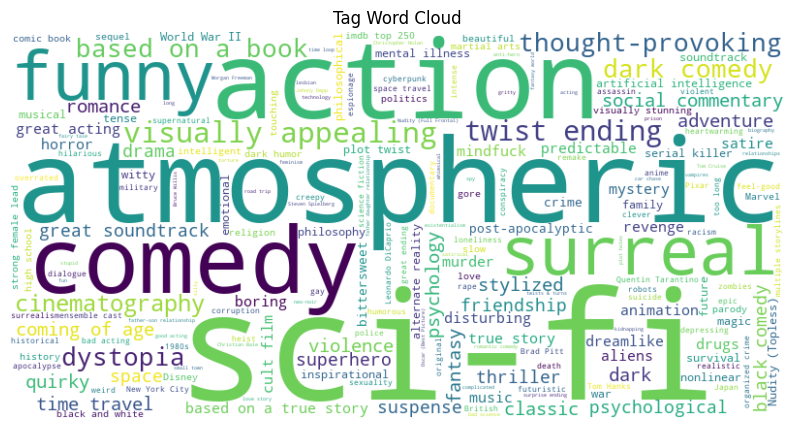

In [22]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Collect the top tags into a Pandas DataFrame
top_tags_pd = top_tags.toPandas()

# Create a dictionary of tag counts
tag_dict = dict(zip(top_tags_pd['tag'], top_tags_pd['count']))
stop = set(STOPWORDS) | {"movie", "film"}  # feel free to add more stopwords
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stop).generate_from_frequencies(tag_dict)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tag_dict)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Tag Word Cloud")
plt.show()


## Average Rating per Genre
Sorted high → low; use to spot genres that consistently over/under-perform and to guide genre-aware baselines.

In [23]:
from pyspark.sql.functions import explode, avg, count

genres_exploded = final_df.withColumn("genre", explode("genres"))

avg_rating_per_genre = (
    genres_exploded
    .groupBy("genre")
    .agg(
        avg("rating").alias("avg_rating"),
        count("*").alias("rating_count")
    )
    .orderBy("avg_rating", ascending=False)  
)

avg_rating_per_genre.show()


+------------------+------------------+------------+
|             genre|        avg_rating|rating_count|
+------------------+------------------+------------+
|         Film-Noir|  3.93366368286445|        3128|
|               War|3.8669055317661454|       11443|
|             Crime|  3.84957201606733|       41824|
|         Animation|3.8262383191840224|       16373|
|             Drama| 3.825190640837399|      126678|
|           Mystery|3.8182326190843225|       25948|
|       Documentary|3.8011627906976746|        6020|
|           Musical|3.7844980752146875|        6754|
|           Western| 3.746814854974248|        3689|
|           Romance|3.7438470553765018|       40956|
|              IMAX|3.7058335309461703|       12651|
|          Thriller| 3.690898005042201|       72984|
|         Adventure|3.6709743548516762|       49756|
|           Fantasy|3.6684484406527664|       28249|
|          Children|3.6648257994136495|       14667|
|            Sci-Fi|3.6643600986571663|       

In [24]:
import plotly.express as px
import pandas as pd

avg_rating_per_genre_pd = (
    avg_rating_per_genre
    .toPandas()
    .sort_values(by="avg_rating", ascending=False)
)
median_val = avg_rating_per_genre_pd["avg_rating"].median()

fig = px.bar(
    avg_rating_per_genre_pd,
    x="avg_rating",
    y="genre",
    orientation="h",
    color="genre",
    text=avg_rating_per_genre_pd["avg_rating"].map(lambda x: f"{x:.2f}"),
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data={"avg_rating": ":.2f"}
)
fig.update_traces(textposition="outside", texttemplate="%{text}", textfont_size=10)

fig.add_vline(
    x=median_val,
    line_dash="dash",
    line_color="red"
)
fig.add_annotation(
    x=median_val,
    y=0, yref="paper",
    text=f"Median: {median_val:.2f}",
    showarrow=False,
    xanchor="left",
    yanchor="bottom",
    font=dict(size=10, color="red"),
    bgcolor="rgba(255,255,255,0.8)"
)

fig.update_layout(
    title="Average Rating per Genre",
    title_x=0.5,
    xaxis_title="Average Rating",
    yaxis_title="Genre",
    showlegend=False,
    template="simple_white",
    height=700,
    margin=dict(l=140, r=160, t=70, b=60)
)

fig.show()


## Genre Trend Over Time (Every Ten Years)
Counts per decade for top genres; peaks show production booms, dips highlight quieter eras. Compare with average rating over time to see if popularity tracks quality.

In [25]:
import plotly.express as px
import pandas as pd
from pyspark.sql.functions import floor, explode

# Prep in Spark
final_df_with_interval = final_df.withColumn("year_interval", (floor(final_df["year"] / 10) * 10))
genres_exploded = final_df_with_interval.withColumn("genre", explode("genres"))
genre_trend = genres_exploded.groupBy("year_interval", "genre").count()

# To pandas
genre_trend_pd = genre_trend.toPandas()
genre_trend_pd["year_interval"] = pd.to_numeric(genre_trend_pd["year_interval"], errors="coerce")

# Top 10 genres by total count
top_10_genres = (
    genre_trend_pd.groupby("genre")
    .sum(numeric_only=True)
    .nlargest(10, "count")
    .index
    if not genre_trend_pd.empty else []
)
trend_top = genre_trend_pd[genre_trend_pd["genre"].isin(top_10_genres)].dropna(subset=["year_interval"])
trend_top = trend_top.sort_values(["genre", "year_interval"])

if trend_top.empty:
    print("No genre trend data to plot.")
else:
    fig = px.line(
        trend_top,
        x="year_interval",
        y="count",
        color="genre",
        markers=True,
        title="Genre Counts Over Time (Top Genres)",
        labels={"year_interval": "Year (by decade)", "count": "Movie Count"},
        color_discrete_sequence=px.colors.qualitative.Set2,
    )
    fig.update_layout(
        template="simple_white",
        title_x=0.5,
        height=600,
        margin=dict(l=60, r=200, t=60, b=60),
        legend_title="Genre"
    )
    fig.update_xaxes(dtick=10)
    fig.show()


- We can spot each genre spikes or dips over time. Typically you will see more titles after the 1970s with visible peaks around the 1990s–2000s, and we see that all genres follow the same pattern expect drama with a more sharp raise.


## Average Rating Over Time
Shows how average ratings shift by release year; combine with residuals to detect eras where the model over/under-predicts.

In [26]:
# Calculate average rating per year
avg_rating_per_year = final_df.groupBy("year").avg("rating").orderBy("year")
avg_rating_per_year.show()


+----+------------------+
|year|       avg(rating)|
+----+------------------+
|1874|               5.0|
|1878|               5.0|
|1883|               3.0|
|1888|               2.5|
|1892|               2.5|
|1894|3.6666666666666665|
|1895| 2.576923076923077|
|1896|2.9722222222222223|
|1897| 3.238095238095238|
|1898|             3.375|
|1899|            3.3125|
|1900|3.2777777777777777|
|1901|               3.0|
|1902|              3.56|
|1903| 3.227272727272727|
|1904|3.0833333333333335|
|1905|2.8333333333333335|
|1906|               3.2|
|1907|               3.5|
|1908|3.3333333333333335|
+----+------------------+
only showing top 20 rows



In [27]:
import plotly.express as px
import pandas as pd

avg_rating_per_year_pd = avg_rating_per_year.toPandas()
avg_rating_per_year_pd["year"] = pd.to_numeric(avg_rating_per_year_pd["year"], errors='coerce')
avg_rating_per_year_pd = avg_rating_per_year_pd.dropna().sort_values(by="year")

# Compute rolling mean if enough points
if len(avg_rating_per_year_pd) >= 5:
    avg_rating_per_year_pd["rolling"] = (
        avg_rating_per_year_pd["avg(rating)"].rolling(window=5, center=True).mean()
    )
else:
    avg_rating_per_year_pd["rolling"] = None

fig = px.line(
    avg_rating_per_year_pd,
    x="year",
    y="avg(rating)",
    markers=True,
    labels={"avg(rating)": "Average Rating", "year": "Year"},
    title="Average Rating per Year",
    color_discrete_sequence=["#4C78A8"]
)

# Add rolling mean if present
if avg_rating_per_year_pd["rolling"].notna().any():
    fig.add_scatter(
        x=avg_rating_per_year_pd["year"],
        y=avg_rating_per_year_pd["rolling"],
        mode="lines",
        name="5-yr rolling",
        line=dict(color="red", dash="dash")
    )

fig.update_layout(
    template="simple_white",
    title_x=0.5,
    height=500,
    margin=dict(l=60, r=60, t=60, b=60),
    legend_title=None
)
fig.show()


- Early years (pre-1915) are noisy and sparse: extreme spikes (5.0) and dips (~2.5) likely reflect very low sample sizes rather than true sentiment.
- From ~1920 to ~1980 the 5‑year rolling mean holds around 3.7–3.9 with modest oscillation—essentially stable mid-to-upper 3s.
- Post-1980 there’s a gentle decline: rolling mean drifts from high-3s down toward mid-3s; by ~2015–2023 it’s ~3.4–3.5. That drop could be real or due to changing rating behavior/platform effects.
- Variability is tighter after 1950—larger sample sizes damp the year-to-year swings, so the downward drift after ~2010 is more likely meaningful than random noise.

# Machine learning or data mining algorithms using Spark MLlib

## Clustering

Bubbles summarize clusters by release year, rating, and size. Labels (C0/C1/…) plus sizes help compare cluster center shifts and density.

In [28]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, avg, count

# Cast and drop nulls
feature_df = (
    final_df.withColumn("year", col("year").cast("int"))
    .select("movieId", "rating", "year")
    .na.drop()
)
assembler = VectorAssembler(inputCols=["rating", "year"], outputCol="features")
feature_df = assembler.transform(feature_df)

feature_sample = feature_df.sample(fraction=0.05, seed=42)
kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(feature_sample)
clusters = model.transform(feature_df)

cluster_summary = clusters.groupBy("prediction").agg(
    avg("year").alias("avg_year"),
    avg("rating").alias("avg_rating"),
    count("movieId").alias("movie_count"),
)


In [29]:
import plotly.express as px

# Make sure cluster_summary exists (run KMeans first)
cluster_summary_pd = cluster_summary.toPandas().sort_values("avg_year")

fig = px.scatter(
    cluster_summary_pd,
    x="avg_year",
    y="avg_rating",
    size="movie_count",
    color="prediction",
    hover_data={"movie_count": ":, "},
    labels={"avg_year": "Average Year", "avg_rating": "Average Rating"},
    title="Average Rating vs. Year by Cluster (size ~ movie_count)",
    color_discrete_sequence=px.colors.qualitative.Set2,
)
fig.update_traces(
    text=cluster_summary_pd["prediction"].map(lambda c: f"C{int(c)}"),
    textposition="top center",
    hovertemplate="Cluster C%{text}<br>Avg Year=%{x:.1f}<br>Avg Rating=%{y:.3f}<br>Movies=%{marker.size:,}",
    textfont_size=10
)
fig.update_layout(
    template="simple_white",
    title_x=0.5,
    height=500,
    margin=dict(l=60, r=80, t=60, b=60),
    yaxis=dict(range=[3.55, 3.85]),
    showlegend=True,
    legend_title="Cluster"
)

fig.show()


- Older clusters (left) are fewer titles with mid‑3.7 ratings; mid‑century cluster peaks near 3.83.

- A large modern cluster (mid‑2000s) sits around 3.73—many titles, slightly lower average than the peak.

- The most recent cluster dips to ~3.6 average rating, despite a sizable count, suggesting newer movies in the data skew lower on average(slightly downward drift nowadays).

## Classification

In [30]:
from pyspark.sql.functions import concat_ws, when, avg, count, first, col, floor
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report

# Aggregate movie-level stats
movie_base = final_df.withColumn("genres_combined", concat_ws("|", "genres"))
movie_stats = movie_base.groupBy("movieId").agg(
first("year").alias("year"),
avg("rating").alias("avg_rating"),
count("rating").alias("rating_count"),
first("genres_combined").alias("genres_combined"),
)

# Label classes (threshold->hypertune)
labeled = (
movie_stats
.withColumn(
"rating_class",
when(col("avg_rating") > 4.0, 2)
.when(col("avg_rating") > 3.0, 1)
.otherwise(0)
)
.withColumn("year", col("year").cast("double"))
.na.drop(subset=["year"])
)

# Class weights (inverse frequency)
class_counts = labeled.groupBy("rating_class").count().toPandas()
total = class_counts["count"].sum()
base_weights = {int(r.rating_class): total / (len(class_counts) * r["count"]) for _, r in class_counts.iterrows()}
boost_high = 1.8 # tweak if desired
weights = {0: base_weights.get(0, 1.0),
1: base_weights.get(1, 1.0),
2: base_weights.get(2, 1.0) * boost_high}
labeled = labeled.withColumn(
"class_weight",
F.when(col("rating_class") == 0, weights[0])
.when(col("rating_class") == 1, weights[1])
.otherwise(weights[2])
)

# Encode genres on the new labeled data
genre_indexer = StringIndexer(inputCol="genres_combined", outputCol="genres_indexed")
indexed = genre_indexer.fit(labeled).transform(labeled)

# Add extra features (only different than baseline)
indexed = indexed.withColumn("log_count", F.log1p("rating_count"))
indexed = indexed.withColumn("year_bucket", floor(col("year") / 5.0))

# Assemble features
assembler = VectorAssembler(
inputCols=["year", "year_bucket", "rating_count", "log_count", "genres_indexed"],
outputCol="features"
)
feature_df = assembler.transform(indexed).na.drop(subset=["features", "rating_class"])

# Train/test split and RF
train_df, test_df = feature_df.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestClassifier(
featuresCol="features",
labelCol="rating_class",
numTrees=180,
maxDepth=10,
maxBins=2048,
featureSubsetStrategy="sqrt",
subsamplingRate=1.0,
)
rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)

# Metrics
evaluator = MulticlassClassificationEvaluator(labelCol="rating_class", predictionCol="prediction")
accuracy = evaluator.setMetricName("accuracy").evaluate(rf_predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(rf_predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(rf_predictions)
f1 = evaluator.setMetricName("f1").evaluate(rf_predictions)
print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

pred_pd = rf_predictions.select("rating_class", "prediction").toPandas()
print("\nPer-class report:")
print(classification_report(pred_pd["rating_class"], pred_pd["prediction"], target_names=["Low", "Medium", "High"]))

# Confusion matrix (normalized)
rf_predictions_pd = rf_predictions.select("rating_class", "prediction").toPandas()
conf = confusion_matrix(
rf_predictions_pd["rating_class"],
rf_predictions_pd["prediction"],
labels=[0, 1, 2],
normalize="true"
)
conf_df = pd.DataFrame(conf, index=["Low", "Medium", "High"], columns=["Low", "Medium", "High"])

fig = px.imshow(
conf_df,
text_auto=True,
color_continuous_scale="Blues",
aspect="auto",
labels={"x": "Predicted Class", "y": "True Class", "color": "Proportion"},
title="Normalized Confusion Matrix"
)
fig.update_layout(
template="simple_white",
title_x=0.5,
height=400,
margin=dict(l=80, r=80, t=60, b=60)
)
fig.update_traces(texttemplate="%{z:.2f}")
fig.show()


Accuracy: 0.5790 | Precision: 0.5862 | Recall: 0.5790 | F1: 0.5451

Per-class report:
              precision    recall  f1-score   support

         Low       0.52      0.61      0.56      1962
      Medium       0.62      0.70      0.66      2782
        High       0.63      0.05      0.09       764

    accuracy                           0.58      5508
   macro avg       0.59      0.45      0.44      5508
weighted avg       0.59      0.58      0.55      5508



## Regression

In [31]:
from pyspark.sql.functions import avg, count, first, concat_ws, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

movie_base = final_df.withColumn("genres_combined", concat_ws("|", "genres"))
movie_stats = movie_base.groupBy("movieId").agg(
    avg("rating").alias("avg_rating"),
    count("rating").alias("rating_count"),
    first("year").alias("year"),
    first("genres_combined").alias("genres_combined"),
).withColumn("year", col("year").cast("double")).na.drop(subset=["year"])

genre_indexer = StringIndexer(inputCol="genres_combined", outputCol="genres_indexed", handleInvalid="skip")
indexed = genre_indexer.fit(movie_stats).transform(movie_stats)

assembler = VectorAssembler(
    inputCols=["year", "rating_count", "genres_indexed"],
    outputCol="features"
)
feature_df = assembler.transform(indexed).na.drop(subset=["features", "avg_rating"])
# feature_df = feature_df.sample(fraction=0.5, seed=42)  # adjust fraction if needed

train_df, test_df = feature_df.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="avg_rating",
    numTrees=200,
    maxDepth=9,
    maxBins=2048,
    featureSubsetStrategy="auto",
    subsamplingRate=1.0,
    minInstancesPerNode=4,
    minInfoGain=1e-4,
    seed=42,
)
rf_model = rf.fit(train_df)
predictions = rf_model.transform(test_df)
rmse = RegressionEvaluator(labelCol="avg_rating", predictionCol="prediction", metricName="rmse").evaluate(predictions)
print(f"RMSE: {rmse:.4f}")


RMSE: 0.8890


In [32]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Build a pandas DataFrame from Spark predictions
predictions_pd = predictions.select("avg_rating", "prediction").toPandas()

x = predictions_pd["avg_rating"]
y = predictions_pd["prediction"]
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())

# Fit simple regression line y = m*x + b
m, b = np.polyfit(x, y, 1)

fig = px.scatter(
    predictions_pd,
    x="avg_rating",
    y="prediction",
    opacity=0.4,
    color_discrete_sequence=["#2a9d8f"],
    title="Predicted vs Actual Average Rating",
    labels={"avg_rating": "Actual Avg Rating", "prediction": "Predicted Avg Rating"},
)

# Perfect-fit line
fig.add_shape(
    type="line",
    x0=min_val, y0=min_val, x1=max_val, y1=max_val,
    line=dict(color="red", dash="dash"),
    name="Perfect Fit"
)

# Regression line
fig.add_trace(
    go.Scatter(
        x=[min_val, max_val],
        y=[m * min_val + b, m * max_val + b],
        mode="lines",
        line=dict(color="orange", dash="dot"),
        name="Regression"
    )
)

fig.update_layout(
    template="simple_white",
    title_x=0.5,
    height=500,
    margin=dict(l=60, r=60, t=60, b=60),
    showlegend=False
)
fig.update_traces(marker=dict(size=6, line=dict(width=0.5, color="white")))
fig.show()


### Baseline vs Model RMSE

Compare the regression model against a simple global-mean baseline on the same test split.

In [33]:
import math
import pandas as pd
from pyspark.sql.functions import avg as spark_avg

# Global mean across movies
global_mean = movie_stats.agg(spark_avg("avg_rating").alias("global_mean")).first()["global_mean"]

pred_pd = predictions.select("avg_rating", "prediction").toPandas()
model_rmse = math.sqrt(((pred_pd["prediction"] - pred_pd["avg_rating"]) ** 2).mean())
baseline_rmse = math.sqrt(((pred_pd["avg_rating"] - global_mean) ** 2).mean())
print(f"Model RMSE: {model_rmse:.4f} | Baseline RMSE (global mean): {baseline_rmse:.4f}")


Model RMSE: 0.8890 | Baseline RMSE (global mean): 0.9280


### Residuals by Release Year

Residual = prediction − actual. Near-zero lines mean balanced predictions; positive means over-prediction, negative under-prediction. Align this with the average-rating-per-year trend to spot era bias.

In [34]:
import plotly.express as px
import pandas as pd
from pyspark.sql.functions import col, avg as spark_avg

residuals_by_year = (
    predictions
    .select("year", "avg_rating", "prediction")
    .groupBy("year")
    .agg(
        spark_avg(col("prediction") - col("avg_rating")).alias("avg_residual"),
        spark_avg("avg_rating").alias("avg_rating"),
    )
    .orderBy("year")
)

residuals_pd = residuals_by_year.toPandas()
residuals_pd["year"] = pd.to_numeric(residuals_pd["year"], errors="coerce")
residuals_pd = residuals_pd.dropna(subset=["year", "avg_residual"])

fig = px.line(
    residuals_pd,
    x="year",
    y="avg_residual",
    markers=True,
    title="Average Residual by Release Year (prediction - actual)",
    labels={"avg_residual": "Average Residual", "year": "Year"},
    color_discrete_sequence=["#4C78A8"]
)
fig.add_hline(y=0, line_dash="dash", line_color="gray")

fig.update_layout(
    template="simple_white",
    title_x=0.5,
    height=500,
    margin=dict(l=60, r=60, t=60, b=60),
    showlegend=False
)
fig.update_traces(marker=dict(size=6, line=dict(width=0.5, color="white")))
fig.show()


### Regression Line Fit

Points close to the red identity line mean good predictions; RMSE printed above gives the magnitude of error. Use this with the residuals plot to identify systematic bias.

## Association rule mining

In [35]:
from pyspark.sql.functions import collect_list, flatten, array_distinct
from pyspark.ml.fpm import FPGrowth

# Prepare transactions of genres (flatten the nested array and ensure distinct genres)
transactions_df = final_df.groupBy("movieId").agg(array_distinct(flatten(collect_list("genres"))).alias("genres_list"))

# FP-Growth model
fp_growth = FPGrowth(itemsCol="genres_list", minSupport=0.01, minConfidence=0.1)
fp_model = fp_growth.fit(transactions_df)

# Frequent itemsets
fp_model.freqItemsets.show()

# Association rules
fp_model.associationRules.show()



+--------------------+-----+
|               items| freq|
+--------------------+-----+
|            [Sci-Fi]| 2315|
|  [Sci-Fi, Thriller]|  622|
|    [Sci-Fi, Horror]|  571|
|    [Sci-Fi, Action]|  835|
|    [Sci-Fi, Comedy]|  400|
|     [Sci-Fi, Drama]|  462|
|            [Action]| 3585|
|  [Action, Thriller]| 1188|
|[Action, Thriller...|  352|
|    [Action, Comedy]|  717|
|     [Action, Drama]| 1063|
|           [Musical]|  633|
|   [Musical, Comedy]|  308|
|         [Animation]| 1447|
|[Animation, Fantasy]|  372|
| [Animation, Comedy]|  477|
|[Animation, Adven...|  435|
|             [Drama]|12310|
|           [Western]|  422|
|            [Horror]| 3327|
+--------------------+-----+
only showing top 20 rows

+-------------------+-----------+-------------------+------------------+--------------------+
|         antecedent| consequent|         confidence|              lift|             support|
+-------------------+-----------+-------------------+------------------+------------------

### Frequent Itemsets Table:
- This table lists **combinations of genres** (itemsets) and their frequencies.
  - Example: **Sci-Fi** appears in **2,315 movies**, and the combination **Sci-Fi, Thriller** appears in **622 movies**.
- These itemsets help identify **common genre combinations** in the dataset.

In [36]:
import plotly.express as px
import pandas as pd

freq_itemsets_df = (
    fp_model.freqItemsets.toPandas()
    .assign(items_str=lambda df: df["items"].apply(lambda x: ", ".join(x)))
    .sort_values(by="freq", ascending=False)
    .head(10)
)

fig = px.bar(
    freq_itemsets_df,
    x="freq",
    y="items_str",
    orientation="h",
    color="items_str",
    text=freq_itemsets_df["freq"].map("{:,}".format),
    color_discrete_sequence=px.colors.qualitative.Set2,
    labels={"freq": "Frequency", "items_str": "Itemset"},
    title="Top 10 Frequent Genre Itemsets",
)
fig.update_traces(textposition="outside", texttemplate="%{text}", textfont_size=10)
fig.update_layout(
    template="simple_white",
    title_x=0.5,
    showlegend=False,
    height=500,
    margin=dict(l=120, r=120, t=60, b=60),
)
fig.show()


### Top 10 Frequent Genre Itemsets

Most common genre combinations; annotations show frequency. Use to sanity-check genre co-occurrence before looking at association rules.

In [37]:
import plotly.express as px
import pandas as pd

association_rules_df = fp_model.associationRules.toPandas()
association_rules_df["antecedent_str"] = association_rules_df["antecedent"].apply(lambda x: ", ".join(x))
association_rules_df["consequent_str"] = association_rules_df["consequent"].apply(lambda x: ", ".join(x))

# Pivot to matrix for confidence values
rules_matrix = pd.pivot_table(
    association_rules_df,
    values="confidence",
    index="antecedent_str",
    columns="consequent_str",
    aggfunc="mean"
)

fig = px.imshow(
    rules_matrix,
    text_auto=True,
    color_continuous_scale="Blues",
    labels=dict(x="Consequent", y="Antecedent", color="Confidence"),
    title="Association Rules Heatmap (Confidence)",
    aspect="auto"
)
fig.update_layout(
    template="simple_white",
    title_x=0.5,
    height=800,
    width=1000,              # bump width
    margin=dict(l=150, r=150, t=80, b=120),
)
fig.update_xaxes(side="bottom")
fig.update_traces(texttemplate="%{z:.2f}")
fig.show()


### Association Rules Heatmap (Confidence)

Brighter cells = higher confidence for antecedent → consequent. Focus on strong pairs and compare against the frequent itemsets to validate patterns.

In [38]:
import plotly.express as px

fig = px.scatter(
    association_rules_df,
    x="confidence",
    y="lift",
    hover_data={
        "antecedent_str": True,
        "consequent_str": True,
        "confidence": ":.2f",
        "lift": ":.2f"
    },
    title="Confidence vs Lift of Association Rules",
    labels={"confidence": "Confidence", "lift": "Lift"},
    color="confidence",
    color_continuous_scale="Blues"
)
fig.update_layout(
    template="simple_white",
    title_x=0.5,
    height=500,
    margin=dict(l=60, r=60, t=60, b=60),
    showlegend=False
)
fig.show()


###  Confidence vs. Lift Scatter Plot:
- This scatter plot compares the confidence and lift values of association rules.
- Lift measures how much more likely the items in the consequent are observed together than if they were randomly associated. Values greater than 1 indicate a strong association.
- Some rules have both high lift and high confidence, indicating strong relationships between genres, while others may have lower confidence and lift values.